<a href="https://colab.research.google.com/github/LvJiaaaaY/Stock-Prediction-Project/blob/main/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import os
import math
import statistics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from pandas_datareader import data as wb
import yfinance as yfin
yfin.pdr_override()

In [2]:
# Parameter for data
## Security code
stock_code='^FTSE'
## Start Date
start_date='2013-01-01'
## End Date
end_date='2023-06-03'
## Split ratio of train data and validation data
train_rate=0.8
## How many business days to see
input_window_size=10
## How many business days to predict
predict_period_num=1


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get data
df=wb.DataReader(stock_code,start=start_date,end=end_date)['Adj Close'].to_frame()
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2013-01-02,6027.399902
2013-01-03,6047.299805
2013-01-04,6089.799805
2013-01-07,6064.600098
2013-01-08,6053.600098


# Normalize the data

In [3]:
# Normalization and Denormalization constants
denorm_const = df['Adj Close'].iloc[0]
norm_const = 1/denorm_const

denorm_const, norm_const

(6027.39990234375, 0.00016590901818396863)

In [4]:
# Normalize
df = df*norm_const
df.head()

,Adj Close
Date,
2013-01-02,1.000000
2013-01-03,1.003302
2013-01-04,1.010353
2013-01-07,1.006172
2013-01-08,1.004347


# Bollinger Bands

In [5]:
def get_rolling_mean(df_, window):
    return df_.rolling(window).mean()

def get_rolling_std(df_, window):
    return df_.rolling(window).std()

def get_bollinger_bands(rm, rstd):
    upper_band = rm + 2*rstd
    lower_band = rm - 2*rstd
    return upper_band, lower_band

def clip_to_bollinger_bands(df_, window):
    rm = get_rolling_mean(df_, window=window)
    rstd = get_rolling_std(df_, window=window)
    upper_band, lower_band = get_bollinger_bands(rm, rstd)
    return df_.clip(upper=upper_band, lower=lower_band)

In [6]:
def plot_df(df, title="Default Title"):
    ax = df.plot()
    ax.set_xlabel(title)
    ax.get_legend().remove()
    plt.show()

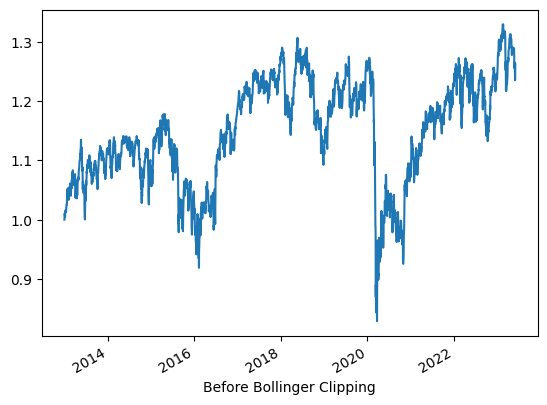

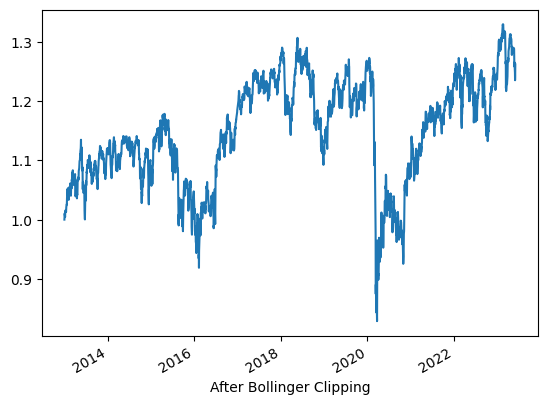

In [7]:
plot_df(df, "Before Bollinger Clipping")
df = clip_to_bollinger_bands(df, input_window_size)
plot_df(df, "After Bollinger Clipping")

After Bollinger Clipping we have first (input_window_size - 1) elements as NaN

In [8]:
df.head(15)

,Adj Close
Date,
2013-01-02,1.000000
2013-01-03,1.003302
2013-01-04,1.010353
2013-01-07,1.006172
2013-01-08,1.004347
2013-01-09,1.011829
2013-01-10,1.012294
2013-01-11,1.015629
2013-01-14,1.013356


In [9]:
data = list(df['Adj Close'])
len(data)

2630

# Train, Validation and Test data

For DNN

Train+Validation : Test = 80 : 20

In [10]:
train_till = int(0.8*len(data))  # this is train + validation

train_raw_data = data[:train_till]
test_raw_data = data[train_till:]

train_features = [train_raw_data[i:i+input_window_size] for i in range(len(train_raw_data)-input_window_size)]
test_features = [test_raw_data[i:i+input_window_size] for i in range(len(test_raw_data)-input_window_size)]

train_labels = train_raw_data[input_window_size:]
test_labels = test_raw_data[input_window_size:]

print(len(train_features), len(train_labels))
print(len(test_features), len(test_labels))

2094 2094
516 516


In [11]:
train_features = pd.DataFrame.from_records(train_features)
test_features = pd.DataFrame.from_records(test_features)

train_labels = pd.DataFrame(train_labels)
test_labels = pd.DataFrame(test_labels)

print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

(2094, 10) (2094, 1)
(516, 10) (516, 1)


# Build the model

In [12]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(10, activation=tf.nn.relu, input_shape=[input_window_size]),
        keras.layers.Dense(5, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [13]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


# Train the model

Without Early Stopping

In [14]:
n_epochs = 500
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print()
        print('.', end='')

history = model.fit(train_features, train_labels, epochs=n_epochs, validation_split=0.2,
                    verbose=0, callbacks=[PrintDot()])


..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
495,0.006096,0.013541,495
496,0.006096,0.013405,496
497,0.006099,0.013437,497
498,0.006103,0.013283,498
499,0.006096,0.013575,499


In [16]:
hist.head()

,loss,val_loss,epoch
0,1.492635,1.095747,0
1,1.146420,0.996719,1
2,1.044717,0.902706,2
3,0.948632,0.814490,3
4,0.858752,0.732461,4


In [17]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    # plt.ylabel('Loss  x($10^{-6}$)')
    plt.ylabel('Loss')
    # plt.plot(hist['epoch'], hist['loss']*1000000, label='Train Loss')
    # plt.plot(hist['epoch'], hist['val_loss']*1000000, label='Validation Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
    # plt.ylim([0, 500])
    plt.legend()

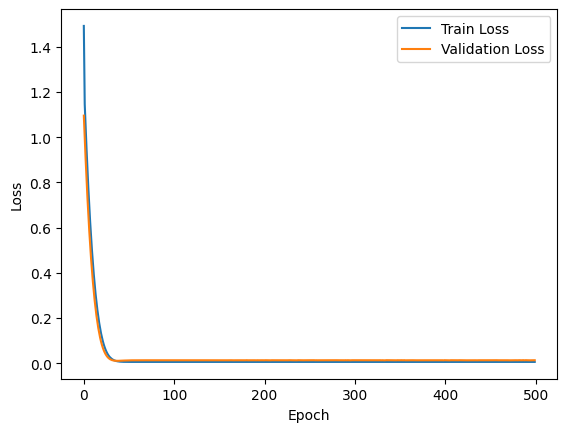

In [18]:
plot_history(history)

With Early Stopping


..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
.........................

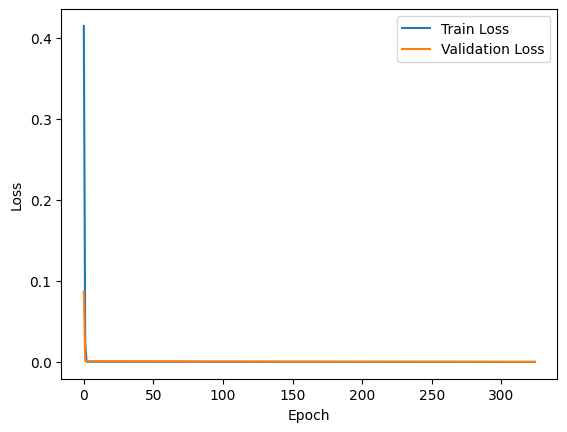

In [19]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_features, train_labels, epochs=n_epochs, validation_split=0.2,
                    verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

# Test on test data

In [20]:
loss = model.evaluate(test_features, test_labels)
print("Mean Squared Error on test data = {}".format(loss))

17/17 [==============================] - 0s 2ms/step - loss: 1.6323e-04
Mean Squared Error on test data = 0.00016322611190844327


# Make Predictions

In [21]:
test_predictions = model.predict(test_features)
test_predictions.shape

17/17 [==============================] - 0s 2ms/step


(516, 1)

In [22]:
test_predictions[:10]

array([[1.147698 ],
       [1.1589361],
       [1.1634326],
       [1.1637261],
       [1.1487902],
       [1.1608771],
       [1.1539226],
       [1.1645557],
       [1.1641649],
       [1.1620436]], dtype=float32)

In [23]:
test_predictions[:10]

array([[1.147698 ],
       [1.1589361],
       [1.1634326],
       [1.1637261],
       [1.1487902],
       [1.1608771],
       [1.1539226],
       [1.1645557],
       [1.1641649],
       [1.1620436]], dtype=float32)

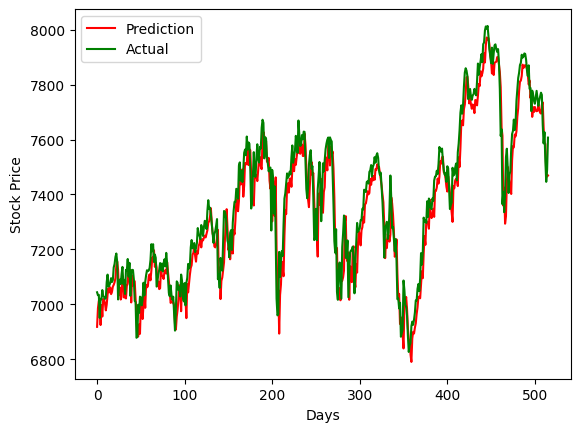

In [24]:
plt.figure()
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.plot(test_predictions*denorm_const, 'r', label='Prediction')
plt.plot(test_labels[0]*denorm_const, 'g', label='Actual')
plt.legend()
plt.show()